In [2]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ---------------------------------------- 3/3 [imblearn]



In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# import user_agents # get info from user_agent (browser_info)
# from ip2geotools.databases.noncommercial import DbIpCity as ip2geo # get location from ip
# from geopy.distance import great_circle # distance btn 2 (lat,long)
# from geopy.geocoders import Nominatim # geocode("place") / reverse("lat,long")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # text feature
from sklearn.model_selection import train_test_split # train-test-split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer # detect & handle NaNs
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder # Ordinal Encoding, Nominal Encoding
from imblearn.under_sampling import RandomUnderSampler # undersampling
from imblearn.over_sampling import RandomOverSampler, SMOTE # oversampling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # Scaling
from sklearn.pipeline import Pipeline, make_pipeline # to make pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector # apply pipeline to each column
from sklearn.linear_model import LinearRegression # if data is small and small_no_features
from sklearn.linear_model import SGDRegressor # if data is large: (can have penalty=constrains)
from sklearn.preprocessing import PolynomialFeatures # for polynomial regresion (then apply scaling after it)
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV # Regularization
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import VotingClassifier, VotingRegressor # Ensemble (Voting)
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor # Bagging & Pasting
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor # Boosting
from sklearn.ensemble import StackingClassifier, StackingRegressor # Stacking
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, RandomizedSearchCV # (Train - Valid - Test) + hyperparameters tunning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV # if data / features is large
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # Evaluate Model: r2=> accuracy, L2-norm: if no outliers, L1-norm: if outliers
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from scipy import stats # Confidence Interval of Accuracy / Loss / Utility
import joblib # save model
from sklearn.decomposition import PCA, IncrementalPCA # till 20K features
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection # >20k features
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE # Manifold could be better than Projection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for classfication problems (larg distance between diffrent classes)
from sklearn.cluster import KMeans, MiniBatchKMeans # spherical dataset (n_cluster by (elbow / silhouette_score / silhoutette_samples))
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN # eps by K-distanceGraph
from sklearn.neighbors import NearestNeighbors # determine nearest neighbor
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.covariance import MinCovDet
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
# Naive using df.diff(s)
from statsmodels.tsa.arima.model import ARIMA # Statstical Models as ARIMA and VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR # Handle Seasonality and Trends
from xgboost import XGBRegressor, XGBClassifier # Machine Learning Model: extract lag features
from prophet import Prophet # fb prophet: trending model for forcasting
# from pandas.tseries.holiday import USFederalHolidayCalendar as Calender
# cal = Calender() # all holidays
# holidays = cal.holidays(start=df.index.min(), end=df.index.max(), return_name=True)
# holidays_df = pd.DataFrame(data=holidays, columns=['holiday']).reset_index().rename(columns={"index":'ds'})
# holidays_df
# holidays_df.groupby('holiday')[['ds']].count()
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import joblib

C:\Users\abood\miniconda3\envs\ml-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv("Datasets-Ready/amman_Ready.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            210384 non-null  object 
 1   Air Dew Point         210384 non-null  float64
 2   Air Temperature (OC)  210384 non-null  float64
 3   Humidity %            210384 non-null  float64
 4   Atmospheric Pressure  210384 non-null  float64
 5   Liquid Precipitation  210384 non-null  float64
 6   Cloud Cover %         210384 non-null  float64
 7   Wind_U                210384 non-null  float64
 8   Wind_V                210384 non-null  float64
dtypes: float64(8), object(1)
memory usage: 14.4+ MB


In [9]:
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [10]:
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [13]:
scaler = RobustScaler()
# scaler = StandardScaler()
split_point = int(len(df) * 0.875)

dl_train = df.iloc[:split_point]
dl_val = df.iloc[split_point: split_point + 4320]
dl_test = df.iloc[split_point + 4320:]
scaler_path = f"Models/Other_Vars/amman_scaler.save"




for col in ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %','Atmospheric Pressure', 'Wind_U', 'Wind_V']:
  dl_train[col] = scaler.fit_transform(dl_train[[col]])
  dl_val[col] = scaler.transform(dl_val[[col]])
  dl_test[col] = scaler.transform(dl_test[[col]])
joblib.dump(scaler, scaler_path)

C:\Users\abood\AppData\Local\Temp\ipykernel_15928\863828856.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_train[col] = scaler.fit_transform(dl_train[[col]])
C:\Users\abood\AppData\Local\Temp\ipykernel_15928\863828856.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_val[col] = scaler.transform(dl_val[[col]])
C:\Users\abood\AppData\Local\Temp\ipykernel_15928\863828856.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

['Models/TCN_Models/amman_scaler.save']

In [27]:
def df_to_X_y_2(df, window_size=6):
  df = df.drop(columns=['time']) 
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = [r for r in df_as_np[i : i + window_size]]
    X.append(row)
    label = [df_as_np[i + window_size][0], df_as_np[i + window_size][1], df_as_np[i + window_size][2], df_as_np[i + window_size][3], df_as_np[i + window_size][4], df_as_np[i + window_size][5], df_as_np[i + window_size][6], df_as_np[i + window_size][7]]
    # label = df_as_np[i + window_size
    y.append(label)
  return np.array(X).astype(np.float32), np.array(y).astype(np.float32)


In [28]:
X_train, y_train = df_to_X_y_2(dl_train, window_size=14) # 14 days ago
X_val, y_val = df_to_X_y_2(dl_val, window_size=14) # 14 days ago
X_test, y_test = df_to_X_y_2(dl_test, window_size=14) # 14 days ago
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((184072, 14, 14),
 (184072, 8),
 (4306, 14, 14),
 (4306, 8),
 (21964, 14, 14),
 (21964, 8))

In [16]:
y_train[0]

array([-0.3       ,  0.35714286, -0.57648296,  0.28735632,  0.        ,
        0.        , -0.55445545,  1.13380282])

In [17]:
lstm_model2 = Sequential()
lstm_model2.add(InputLayer((14, 8)))
lstm_model2.add(LSTM(64, return_sequences=True))
lstm_model2.add(LSTM(128))
lstm_model2.add(Dense(8, 'relu'))
lstm_model2.add(Dense(8, 'linear'))
lstm_model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 14, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              72 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,608 (463.31 KB)

 Trainable params: 118,608 (463.31 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
cp1 = ModelCheckpoint('Models/Other_Vars/amman_lstm_model.keras', save_best_only=True)
lstm_model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [29]:
lstm_model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp1],  batch_size=128)

Epoch 1/20


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 14 and 8 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_2, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,14], [8,256].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 14), dtype=float32)
  • states=('tf.Tensor(shape=(None, 64), dtype=float32)', 'tf.Tensor(shape=(None, 64), dtype=float32)')
  • training=True

# test

In [51]:
df = pd.read_csv("Datasets-Ready/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.drop(['Unnamed: 0', 'Liquid Precipitation', 'Cloud Cover %'], axis=1, inplace=True)


In [52]:
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


In [53]:
df.drop(['hour', 'month'], axis=1, inplace=True)

# --- Scaling Target Variables Only ---
target_columns = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %', 'Atmospheric Pressure', 'Wind_U', 'Wind_V']
scaler = RobustScaler()
scaler_path = "Models/Other_Vars/amman_scaler.save"

split_point = int(len(df) * 0.875)
dl_train = df.iloc[:split_point].copy()
dl_val = df.iloc[split_point:split_point + 4320].copy()
dl_test = df.iloc[split_point + 4320:].copy()

# Fit scaler on training set only, then transform all splits
dl_train[target_columns] = scaler.fit_transform(dl_train[target_columns])
dl_val[target_columns] = scaler.transform(dl_val[target_columns])
dl_test[target_columns] = scaler.transform(dl_test[target_columns])


In [58]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 48, 128)             │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3072)                │         789,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 144)                 │         442,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 24, 6)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,696,400 (6.47 MB)

 Trainable params: 1,696,400 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:


joblib.dump(scaler, scaler_path)

# --- Prepare LSTM Inputs ---
def df_to_X_y_multistep(df, input_window=48, output_window=24, target_cols=['Air Dew Point', 'Air Temperature (OC)', 'Humidity %','Atmospheric Pressure', 'Wind_U', 'Wind_V']):
    df = df.drop(columns=['time'])
    df_as_np = df.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np) - input_window - output_window):
        X.append(df_as_np[i:i + input_window])
        y.append(df_as_np[i + input_window:i + input_window + output_window, :6])  # First 6 columns = targets
    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)

X_train, y_train = df_to_X_y_multistep(dl_train, input_window=48, output_window=24)
X_val, y_val = df_to_X_y_multistep(dl_val, input_window=48, output_window=24)
X_test, y_test = df_to_X_y_multistep(dl_test, input_window=48, output_window=24)

# --- Build & Train Model ---
model = Sequential()
model.add(InputLayer((48, 10)))  # 48 time steps, 8 features
model.add(LSTM(128, return_sequences=True))  # Still need full sequence
model.add(LSTM(256))  # Outputs context vector

# Repeat vector to match output time steps (24)
model.add(Dense(24 * 128, activation='relu'))  # Upsample
model.add(Dense(24 * 6))  # 24 steps * 6 vars
model.add(Reshape((24, 6)))  # Final output shape

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
cp = ModelCheckpoint('Models/Other_Vars/amman_lstm_model.keras', save_best_only=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, callbacks=[cp], batch_size=128)

Epoch 1/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 935s 647ms/step - loss: 0.3835 - root_mean_squared_error: 0.6185 - val_loss: 0.4048 - val_root_mean_squared_error: 0.6362
Epoch 2/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 933s 649ms/step - loss: 0.3335 - root_mean_squared_error: 0.5775 - val_loss: 0.3941 - val_root_mean_squared_error: 0.6278
Epoch 3/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 983s 649ms/step - loss: 0.3070 - root_mean_squared_error: 0.5540 - val_loss: 0.4263 - val_root_mean_squared_error: 0.6529
Epoch 4/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 921s 641ms/step - loss: 0.2639 - root_mean_squared_error: 0.5137 - val_loss: 0.4501 - val_root_mean_squared_error: 0.6709
Epoch 5/15
1072/1438 ━━━━━━━━━━━━━━━━━━━━ 3:48 623ms/step - loss: 0.2188 - root_mean_squared_error: 0.4678

KeyboardInterrupt: 

687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


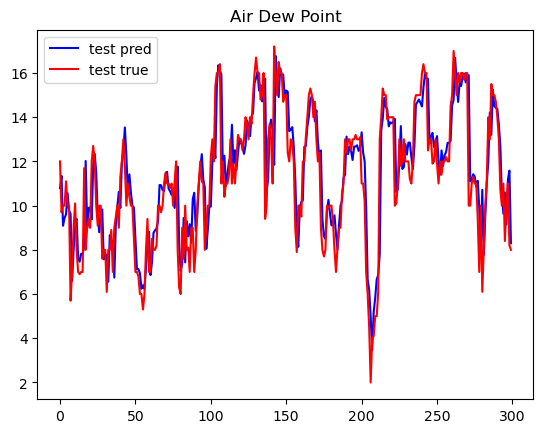

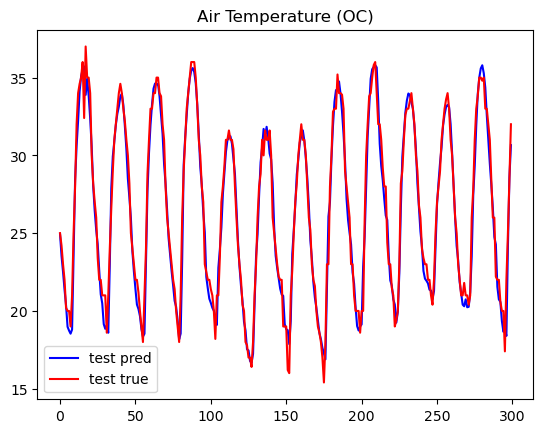

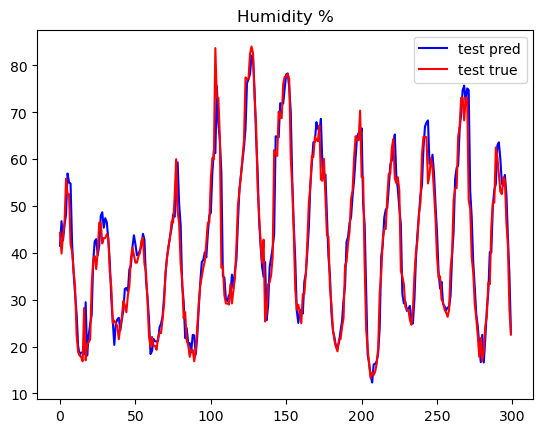

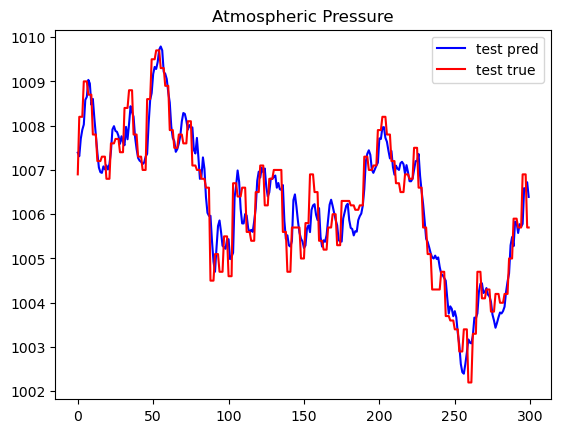

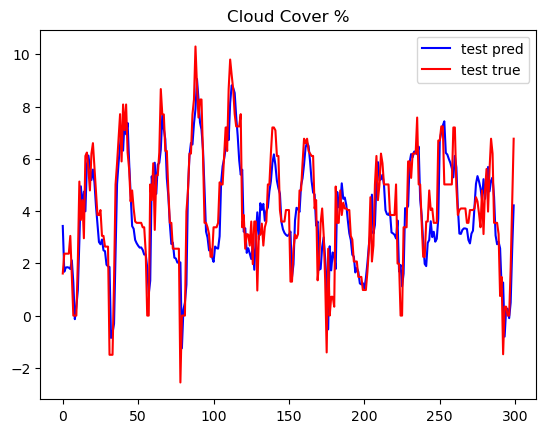

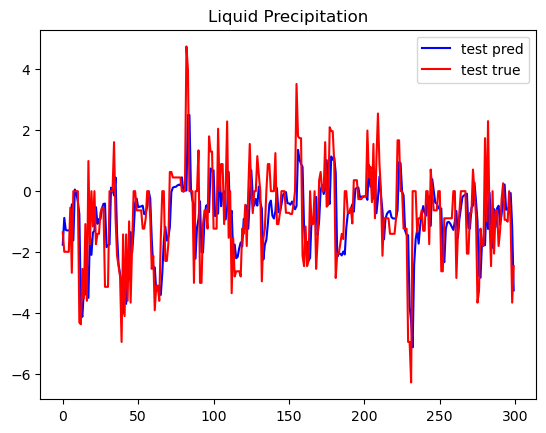

In [47]:
y_test_preds = lstm_model.predict(X_test)

# inverse-transform all predictions and true values
# y_test_preds_inv = scaler.inverse_transform(y_test_preds)
# y_test_true_inv = scaler.inverse_transform(y_test)

# plot each column
for i in range(6):
    plt.plot(y_test_preds_inv[:300, i], c='blue', label='test pred')
    plt.plot(y_test_true_inv[:300, i], c='red', label='test true')
    plt.title(target_columns[i])
    plt.legend()
    plt.show()

In [42]:
df.columns

Index(['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
       'Atmospheric Pressure', 'Wind_U', 'Wind_V', 'time', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos'],
      dtype='object')

# PatchTST

In [67]:
!pip install transformers datasets accelerate

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.4 MB 8.3 MB/s eta 0:00:02
   ------------ --------------------------- 3.1/10.4 MB 10.8 MB/s eta 0:00:01
   --------------------------- ------------ 7.1/10.4 MB 13.2 MB/s eta 0:00:01
   ---------------------------------- ----- 8.9/10.4 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 12.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 15.4 MB/s eta 0:00:00

   -------- -------------------------------  2/10 [regex]
   ------------ ---------------------------  3/10 [dill]
   ---------------- -----------------------  4/10 [multiprocess]
   -------------------- -------------------  5/10 [huggingface-hub]
   -------------------- -------------------  5/10 [huggingface-hub]
   -

In [35]:
import pandas as pd
import numpy as np
import torch
from darts import TimeSeries

In [36]:
df = pd.read_csv("Datasets-Ready/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('time', inplace=True)

# Add cyclical features
   
df['month'] = df.index.month
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Define target variables
target_cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
               'Atmospheric Pressure', 'Wind_U', 'Wind_V']

series = TimeSeries.from_dataframe(df, value_cols=target_cols)

In [37]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTForPrediction, PatchTSTConfig
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ----------- CONFIGURATION -----------
input_length = 96  # past 4 days
forecast_horizon = 48  # predict next 2 days
batch_size = 16
epochs = 30
learning_rate = 1e-4

# ------------- DEVICE ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Define inputs and targets
target_cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
               'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical_cols = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos','dow_sin', 'dow_cos']
input_cols = target_cols + cyclical_cols

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[input_cols])
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=input_cols)
data_np = scaled_df.values

Using: cuda


In [38]:
class WeatherDataset(Dataset):
    def __init__(self, data, input_len, forecast_len):
        self.data = data
        self.input_len = input_len
        self.forecast_len = forecast_len

    def __len__(self):
        return len(self.data) - self.input_len - self.forecast_len

    def __getitem__(self, idx):
        input_seq = self.data[idx : idx + self.input_len]
        target_seq = self.data[idx + self.input_len : idx + self.input_len + self.forecast_len, :6]  # only targets
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

train_size = int(len(data_np) * 0.95)
train_data = data_np[:train_size]
val_data = data_np[train_size:]

train_dataset = WeatherDataset(train_data, input_length, forecast_horizon)
val_dataset = WeatherDataset(val_data, input_length, forecast_horizon)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [39]:
config = PatchTSTConfig(
    context_length=96,
    prediction_length=48,
    patch_length=24,
    stride=12,
    num_input_channels=12,  # 6 weather + 6 features
    target_dim=6,           # ✅ only 6 outputs
    target_names=['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                  'Atmospheric Pressure', 'Wind_U', 'Wind_V'],  # ✅ optionally clarify
    d_model=128,
    n_heads=8,
    num_layers=5,
    dropout=0.1
)

model = PatchTSTForPrediction(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.SmoothL1Loss()

In [40]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(past_values=inputs)
        preds = outputs[0][:, :, :6]
        loss = loss_fn(preds, targets)
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [41]:
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(past_values=inputs)
        preds = outputs[0][:, :, :6]
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_patchtst.pt")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:13<00:00, 25.29it/s]


Epoch 1 | Train Loss: 0.2017 | Val Loss: 0.1917


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:20<00:00, 24.92it/s]


Epoch 2 | Train Loss: 0.1940 | Val Loss: 0.1913


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:13<00:00, 25.29it/s]


Epoch 3 | Train Loss: 0.1900 | Val Loss: 0.1914


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:11<00:00, 25.40it/s]


Epoch 4 | Train Loss: 0.1851 | Val Loss: 0.1928


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:12<00:00, 25.35it/s]


Epoch 5 | Train Loss: 0.1790 | Val Loss: 0.1985


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:11<00:00, 25.40it/s]


Epoch 6 | Train Loss: 0.1713 | Val Loss: 0.2021


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████| 12483/12483 [08:11<00:00, 25.39it/s]


Epoch 7 | Train Loss: 0.1630 | Val Loss: 0.2073
Early stopping at epoch 7


In [6]:
# from tqdm import tqdm

# # Ensure model is in training mode and on the correct device
# model.train()
# model.to(device)

# for epoch in range(epochs):
#     total_loss = 0
#     for inputs, targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
#         # Move to GPU
#         inputs = inputs.to(device)     # (B, 168, 12)
#         targets = targets.to(device)   # (B, 120, 6)

#         optimizer.zero_grad()

#         # 1) Forward pass: model returns a tuple (predictions, ...)
#         outputs = model(past_values=inputs)
#         # 2) Slice to keep only the first 6 channels
#         preds = outputs[0][:, :, :6]    # (B, 120, 6) :contentReference[oaicite:0]{index=0}

#         # 3) Compute loss and backpropagate
#         loss = loss_fn(preds, targets)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     avg_loss = total_loss / len(dataloader)
#     print(f"Epoch {epoch+1} – Avg Loss: {avg_loss:.4f}")

Epoch 1/20: 100%|████████████████████████████████████████████████████████████████| 13131/13131 [19:45<00:00, 11.08it/s]


Epoch 1 – Avg Loss: 0.5332


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████| 13131/13131 [19:38<00:00, 11.14it/s]


Epoch 2 – Avg Loss: 0.4970


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████| 13131/13131 [19:28<00:00, 11.23it/s]


Epoch 3 – Avg Loss: 0.4607


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████| 13131/13131 [19:29<00:00, 11.22it/s]


Epoch 4 – Avg Loss: 0.4254


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████| 13131/13131 [19:28<00:00, 11.24it/s]


Epoch 5 – Avg Loss: 0.3914


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████| 13131/13131 [19:29<00:00, 11.23it/s]


Epoch 6 – Avg Loss: 0.3590


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████| 13131/13131 [19:31<00:00, 11.21it/s]


Epoch 7 – Avg Loss: 0.3328


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████| 13131/13131 [19:28<00:00, 11.24it/s]


Epoch 8 – Avg Loss: 0.3107


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████| 13131/13131 [19:26<00:00, 11.26it/s]


Epoch 9 – Avg Loss: 0.2917


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:28<00:00, 11.24it/s]


Epoch 10 – Avg Loss: 0.2758


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:27<00:00, 11.25it/s]


Epoch 11 – Avg Loss: 0.2629


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:26<00:00, 11.25it/s]


Epoch 12 – Avg Loss: 0.2523


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:27<00:00, 11.25it/s]


Epoch 13 – Avg Loss: 0.2433


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:27<00:00, 11.25it/s]


Epoch 14 – Avg Loss: 0.2353


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:28<00:00, 11.24it/s]


Epoch 15 – Avg Loss: 0.2282


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:26<00:00, 11.25it/s]


Epoch 16 – Avg Loss: 0.2221


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:27<00:00, 11.25it/s]


Epoch 17 – Avg Loss: 0.2167


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:26<00:00, 11.26it/s]


Epoch 18 – Avg Loss: 0.2119


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:27<00:00, 11.25it/s]


Epoch 19 – Avg Loss: 0.2078


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████| 13131/13131 [19:27<00:00, 11.25it/s]

Epoch 20 – Avg Loss: 0.2039


In [37]:
print("Predictions:", predictions.shape)  # should be (B, 120, 6)
print("Targets:", targets.shape)          # should be (B, 120, 6)

Predictions: torch.Size([32, 120, 12])
Targets: torch.Size([32, 120, 6])


In [7]:
model.eval()

PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=24, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps

In [21]:
df_test = pd.read_csv("Amman_test_data/amman_test.csv")

In [23]:
df_test['month'] = df_test.index.month
df_test['hour'] = df_test.index.hour
df_test['dayofweek'] = df_test.index.dayofweek
df_test['dow_sin'] = np.sin(2 * np.pi * df_test['dayofweek'] / 7)
df_test['dow_cos'] = np.cos(2 * np.pi * df_test['dayofweek'] / 7)
df_test['hour_sin'] = np.sin(2 * np.pi * df_test['hour'] / 24)
df_test['hour_cos'] = np.cos(2 * np.pi * df_test['hour'] / 24)
df_test['month_sin'] = np.sin(2 * np.pi * df_test['month'] / 12)
df_test['month_cos'] = np.cos(2 * np.pi * df_test['month'] / 12)

In [22]:
df_test['time'] = pd.to_datetime(df_test['Unnamed: 0'])
df_test.set_index('time', inplace=True)



In [24]:
df_test = df_test[df_test.index > pd.to_datetime("2024-01-01")]

In [25]:
input_cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
              'Atmospheric Pressure', 'Wind_U', 'Wind_V',
              'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']

scaled_test_data = scaler.transform(df_test[input_cols])

In [26]:

test_dataset = WeatherDataset(scaled_test_data, input_length, forecast_horizon)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [27]:
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(past_values=inputs)
        predictions = outputs[0][:, :, :6]

        all_preds.append(predictions.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

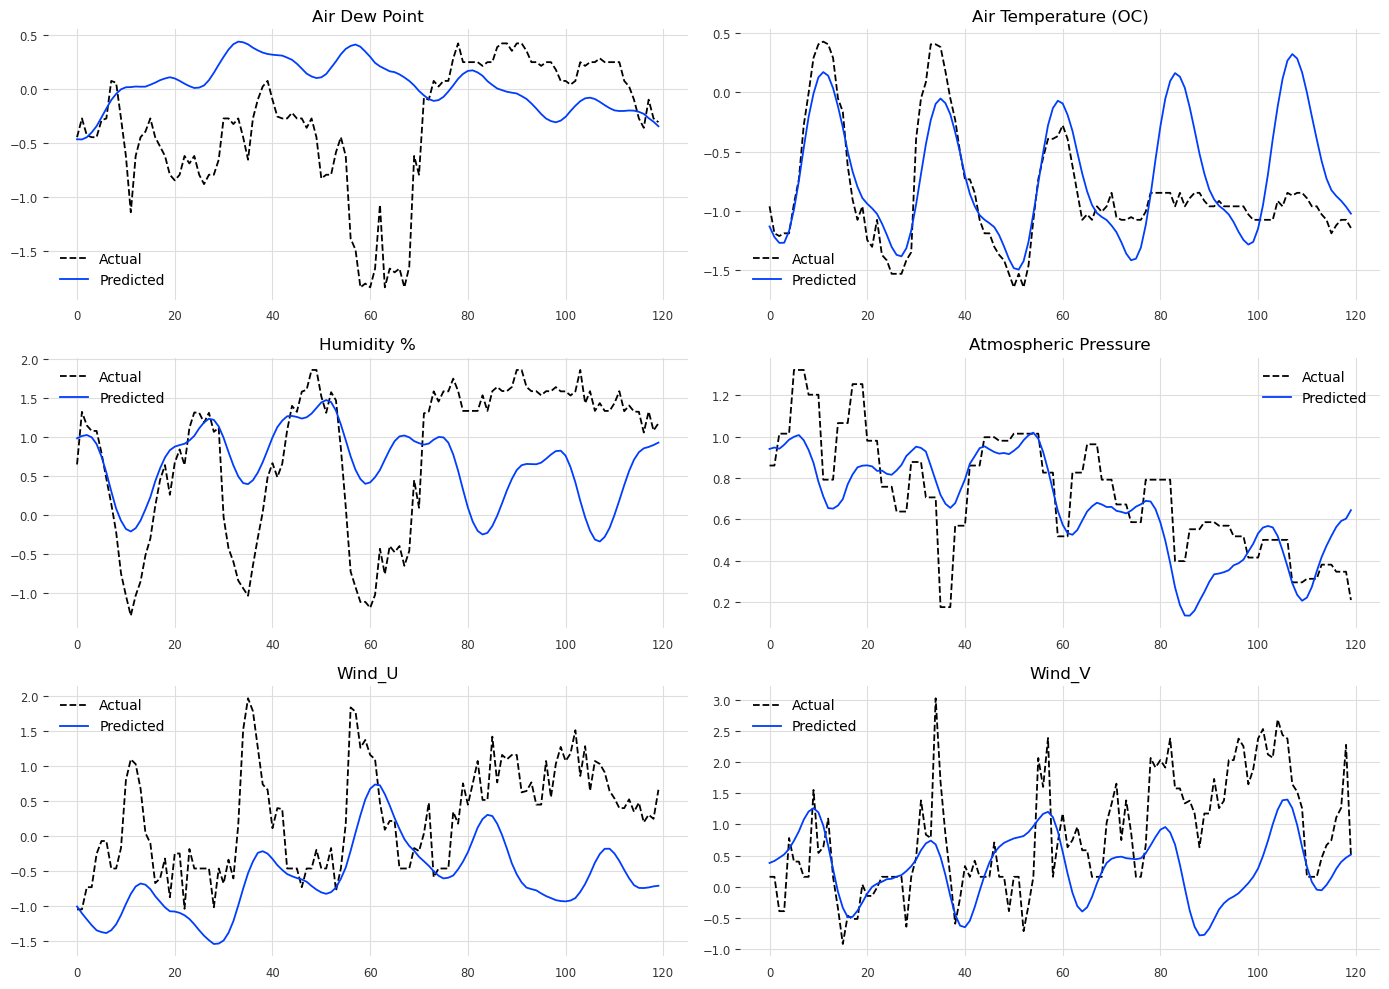

In [28]:
feature_names = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                 'Atmospheric Pressure', 'Wind_U', 'Wind_V']

sample_idx = 0  # you can try others

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

for i in range(6):
    axs[i].plot(all_targets[sample_idx, :, i], label="Actual", linestyle="dashed")
    axs[i].plot(all_preds[sample_idx, :, i], label="Predicted")
    axs[i].set_title(feature_names[i])
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()